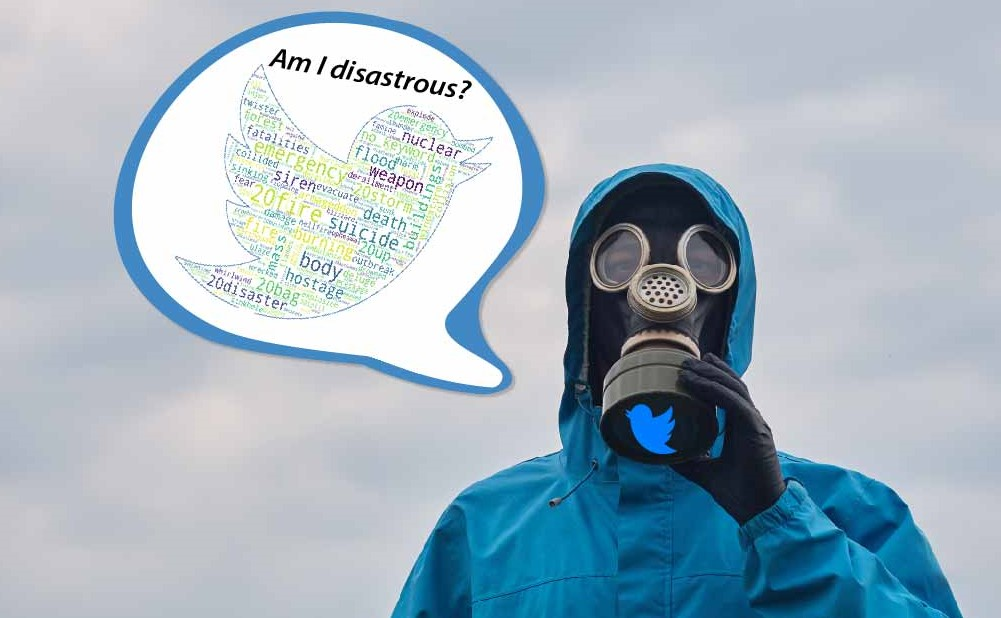

## **Edit**:
I made [another tutorial on kaggle](https://www.kaggle.com/mitramir5/simple-bert-with-video/edit/run/43188732) about word embeddings and how BERT classifies the text with them. From that notebook this video is one thing that can be useful for people who want to know more about embeddings and text classification. 

In [ ]:
%%HTML
<a id = "Word_Embeddings"></a>
<center>
<iframe width="700" height="315" src="https://www.youtube.com/embed/t5wdTK-QtLA" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" style="position: relative;top: 0;left: 0;" allowfullscreen ng-show="showvideo"></iframe>
</center>

<font size="+3" color="blue"><b>Table of content</b></font><br>

*  [Into](#intro)

*  [Importing packages and data](#Importing)

*  [Data analysis and visualization](#Data_analysis)

*  [Adding Features](#Adding_Features)

*  [Text Cleaning](#Text_Cleaning)

*  [LinearSVM, RidgeClassifier, GaussianNB models](#simple_models)

*  [Text embedding](#Text_embedding)

*  [Neural Network model](#NeuralNetwork_model)

*  [Cross Validation and visualization of NN](#Cross_Validation_for_NN)

* [How to do GridSearch for parameter tuning in neural networks](#gridsearch)

<a id="intro"></a>
# Introduction

This is a kernel for data analysis, visualization, cleaning and prediction from beginner to expert level. I will use what ever could help me with predicting a better result and construct easy to sophisticated models. I'd love to hear from you and make this notebook a perfect explaination and guide, so feel free to ask me what ever!
I'll try to explain the code i wrote and packages I use through out this kernel as much as possible.

Let's dive in...

<a id="Importing"></a>
# **Importing Packages and our dataset**

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns # for beautiful plots

# for word cloud
from PIL import Image
from wordcloud import WordCloud 

# for preprocessing

from wordcloud import STOPWORDS
import regex as re
import string
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
#!pip install sentencepiece
import sentencepiece

# For making models

from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# for our Neural Netword model

from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import Constant

# For checking and evaluating our models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold


In [ ]:
#!pip install tensorflow-hub
#!pip install tf-nightly
import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)

In [ ]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
ids = test.id

print('shape of training set: ', train.shape)
print('shape of testing set: ', test.shape)

<a id="Data_analysis"></a>
As we can see the traning data is about 2 times bigger than the testing data (which can be very useful because we have more data to train our model) and has 5 columns. The one column that the testing lacks is the target that we have to predict and submit to Kaggle!

OK, let's look at what our data holds:

In [ ]:
train.head(2)

**ID**: the identification number of each tweet that separates it from other tweets.

**Keyword**: The one specific word that has been found in many tweets

**Location**: where was the person who tweeted?

**text**: The most important field that we rely our prediction on

**target**: Is the tweet disastrous or not?

**Null Values and unuseful data:** 

Before building our model, we have to check whether each column contains enough information that can actually help us with the prediction.

* Firstly we concatinate the training and testing set for an overall feature analysis and cleaning. 

* we'll delete the ids. Because their all unique for each tweet and there is no pattern among them.
* Also we'll see how many null values each column has.

In [ ]:
df_concat = pd.concat([train, test], axis = 0) # concatinating along the 0 axis(rows).
for df in [train, test, df_concat]:
    df.drop(columns = ['id'], inplace = True) # dropping id and inplacing it


print('null values of each field:\n', df_concat.isnull().sum())


As we can see more than 30 precent of the location and about 8 precent of keyword is null. Let's fill the null values with *no_keyword* and *no_location* for better undrestanding and viz.

In [ ]:
for df in [train, test, df_concat]:

    df.keyword.fillna('no_keyword', inplace = True)
    df.location.fillna('no_location', inplace = True)



**Location:**

Can this field help? lets see what are the most common locations and how many there are.
This field contains users inputs and were not automatically generated. take a look at it. it's very dirty and even same places don't have the same name. but first it's good to take a look at the common places people tweet from.

In [ ]:
# top 30 locations in the dataset

top_30 = df_concat.groupby(['location']).count().text.sort_values(ascending = False)[:30]

# plot the top 30

plt.figure(figsize = (6,10))
sns.barplot(x = top_30, y = top_30.index);
plt.xlabel('number of tweets');


The list of common places include strings like 'earth' or 'Everywhere'! It's because this field is the users input and were not automatically generated and is very dirty. we'll get rid of it right away. 

> *But if you're still curious that this field may help us in our prediction in someway, I actually did an experiment and used it with get_dummies, but got slightly worse results. This confirms that this field not only doesn't help but also can be harmful!)*

In [ ]:
for df in [train, test, df_concat]:
    
    df.drop(columns = ['location'], inplace = True)

**Keyword:**

This is one word or phrase from the text field. Let's see what keywords were used most often and which usually came with disastrous tweets.

In [ ]:

tweet_mask = np.array(Image.open("../input/twitterlogo3/twitter-logo-png-transparent.png"))
wc = WordCloud(collocations=False,
               background_color="white",
               max_words=200,
               mask = tweet_mask,
               contour_color='steelblue',
               contour_width=10,)

# Generate a wordcloud
wc.generate(" ".join(train['keyword']))


# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
# top 10 most used keywords in disastrous and non_disastrous tweets
# We'll use training set for this 

count_dis_keywords = train[train.target == 1].groupby(['keyword']).count().sort_values(by = 'target', ascending = False)[:30]
count_non_dis_keywords =  train[train.target == 0].groupby(['keyword']).count().sort_values(by = 'target', ascending = False)[:30]

In [ ]:
sns.set(style="white")

 # increasing the fontsize for better viz

fig, ax_ = plt.subplots(1, 2, figsize = (25,15));

# left side, the plot for keywords in disastrous tweets

sns.barplot(x = count_dis_keywords.target, # count of each keyword
        y = count_dis_keywords.index, # index of this df is our keywords
        ax = ax_[0],
        palette = 'Reds_r',
        label = 'dis')



# right side, the plot for non_disastrous tweets

sns.barplot(x = count_non_dis_keywords.target, 
            y = count_non_dis_keywords.index, 
            ax = ax_[1],
            palette = 'Greens_d',
            label = 'non_dis')


for ax in [ax_[0], ax_[1]]:
    
    ax.set_title('Number of tweets per keyword',
                 fontsize = 20) # setting title
    
    ax.set_ylabel('') 
    ax.set_xlabel('')

    ax.set_yticklabels(labels =ax.get_yticklabels() ,
                       fontsize = 15)

**Now let's see them together...**

In [ ]:
counting_tweets = train.groupby(['keyword', 'target']).count().reset_index()

counting_tweets = pd.pivot_table(counting_tweets, 
               values = 'text', # count of tweets in here
               index = 'keyword',# index is keyword
               columns = 'target') # columns will be 0 and 1



# let's have the keywords most used in disastrous tweets on top
# also some keywords don't appear in both categories 
# so we fill the null values with 0

counting_tweets = counting_tweets.fillna(0).sort_values([0, 1], ascending = [True, False])
counting_tweets

In [ ]:

counting_tweets = counting_tweets.apply(lambda x: x*100/sum(x), axis=1)

In [ ]:
# top 30 disastrous 
# and their distribution in dis and non_dis tweets 

counting_tweets.head(30).plot(kind="bar", stacked=True,
                              figsize = (15,5),
                              color = ['green', 'red']);
plt.title('Top disastrous keywords');

In [ ]:
# top 30 non_disastrous
counting_tweets.tail(30).plot(kind="bar", stacked=True,
                              figsize = (15,5),
                              color = ['green', 'red']);
plt.title('Top non_disastrous keywords');

<a id="Adding_Features"></a>
# **Checking the distribution and generating new features**

One important thing we have to check is whether or not our test and training set are from the same dataset. It's important because we have to know if there is enough similarity between them that we can rely on our training set to predict the testing set. Sometimes when they're not so similar, a more biased prediction can give us better scores. One way to check this is to check the distribution of the data, like here we can check the distribution of keywords and whether or not both training and testing set have the same keywords.

In [ ]:
assert train.keyword.all() == test.keyword.all()

# this statement asserts each serie and doesn't give an error when the two parts are equal.
# here we didn't get any error so we can assume that they are indeed from one source.

After checking the keywords, we want to check the distribution of the datasets fields and it's features. We'll get to know our dataset by generating new features.

In [ ]:
# count of words in every text

df_concat['word_count'] = \
df_concat['text'].apply(lambda x : len(str(x).split()))

# count of stopwords
# stopwords : words like 'is', 'he', 'a', 'she'

df_concat['stop_words'] =\
df_concat['text'].apply(lambda x : len([w for w in str(x).lower().split() \
                                    if w in STOPWORDS]))

# how many urls were in the text

df_concat['url_count'] =\
df_concat['text'].apply(lambda x : len([w for w in str(x).lower().split() \
                                    if 'http' in w or 'https' in w]))


# the mean of the words in each tweet

df_concat['mean_word_length'] =\
df_concat['text'].apply(lambda x :\
                        np.mean([len(w) for w in str(x).split()]))

# how many characters like '!', '#', '.', '\' were in text

df_concat['punc_count'] = \
df_concat['text'].apply(lambda x :\
                        len([w for w in str(x) \
                        if w in string.punctuation]))

# how many hashtags?

df_concat['hashtag_count'] = \
df_concat['text'].apply(lambda x :\
                        len([w for w in str(x) \
                        if w == '#']))

# how many mentions with '@'

df_concat['mention_count'] = \
df_concat['text'].apply(lambda x :\
                        len([w for w in str(x) \
                        if w == '@']))

# now we separate the concatinated dataset
# to observe each dataset's behaviour

train1 = df_concat.iloc[ : train.shape[0], :]
test1 = df_concat.iloc[train.shape[0] :, :]

Now let's see what these features can tell us!

In [ ]:

fields = ['word_count', 'stop_words', 
         'mean_word_length', 'punc_count','hashtag_count', 
         'mention_count', 'url_count',]



plt.style.use('seaborn-whitegrid')

f, axes = plt.subplots(len(fields), 1,
                       figsize = (20, 100))


for i, field in enumerate(fields):

    s = sns.distplot(train1.loc[:, field], 
                 ax = axes[i], kde_kws={'bw':5})
    
    sns.distplot(test1.loc[:, field], 
                 ax = axes[i], kde_kws={'bw':5})
    
    axes[i].set_title(field, fontsize = 20)
    
    axes[i].tick_params(labelsize = 20);
    
    axes[i].set_xlabel('', fontsize = 20);
    
    s.legend(labels = ['train', 'test'], fontsize = 20)

As we saw here the distribution of training and testing set are very alike and we can assume that indeed these two are from one dataset.

Now we'll see how these features differ in disastrous and non_disastrous tweets.


In [ ]:

plt.style.use('seaborn-whitegrid')

f, axes = plt.subplots(len(fields), 1,
                       
                       figsize = (20, 100))

train1_1 = train1[train1.target != 0]
train1_0 = train1[train1.target != 1]


for i, field in enumerate(fields):
    


    sns.distplot(train1_0.loc[:, field], ax = axes[i],
                label = 'zeros', kde_kws={'bw':5})
    
    
    s = sns.distplot(train1_1.loc[:, field], ax = axes[i],
                    label = 'ones', kde_kws={'bw':5})
    
    
    axes[i].set_title(field, fontsize = 20)
    
    axes[i].tick_params(labelsize = 20);
    
    axes[i].set_xlabel('');

    
    s.legend(labels = ['Zeros', 'Ones'], fontsize = 20)


## **Conclusion from data generation**:
Disastrous tweets(which are usually formal and from news), have a less varied **length, stop word count, and mean word length** due to the more bell shaped the curve of them are. They are also a little longer than non_disastrous tweets which are casual and written by people.
other features like hashtag,mention and url count are very much the same and can't help us much in our prediction.


<a id="Text_Cleaning"></a>
#  **visualizing the target Distribution**
The next thing we have to check and be careful about is the distribution of target. 

If we have more ones than zeros, then we should use Stratified Cross Validation for our training process.
Here we can use pie chart because our distribution isn't that much 

In [ ]:
fig, ax_ = plt.subplots(figsize = (20,5))

explode = (0.09, 0.09)

ax_.pie(x = train.groupby(['target']).count()['text'],
        labels = ['zeros', 'ones'], shadow = True,  
        pctdistance = '%10f%%', explode= explode,
        startangle = 0, textprops={'size': 'larger'});

ax_. set_title('Distribution of zeros and ones', fontsize = 15);

we see that they are somehow equally distributed, but we're safer with a stratified kfold to sure we have the same proportion in every fold.

# **ngrams**

This is were we dive into the actuall text and see how clean or dirty it is. Lets first see what words(unigrams) the text contains:

In [ ]:
def make_ngrams(text, n):
    
    c_vectorizer = CountVectorizer(ngram_range = (n,n)).fit(text)
    
    vocab = c_vectorizer.transform(text)

    count_of_each_ngram = vocab.sum(axis = 0)
    
    word_and_count = [(word, count_of_each_ngram[0, i]) for word, i in c_vectorizer.vocabulary_.items()]
    
    # sorting
    word_and_count = {k:v for k,v in sorted(word_and_count, key = lambda x: x[1], reverse=True) }
    
    return word_and_count

In [ ]:
make_ngrams(df_concat.text, 1)


From what we see here, there are lots of repetetive words that are getting in our way to get to important, words that define the content of tweets. We'd better clean our text and then check on uni/bio/trigrams.

# Text Cleaning

In natural language processing, one of the best method for text classification is using pretrained text. I'll explain embeddings in another kenel but for now the most important thing to know is that here with GloVe we can have a dictionary of words, a dictionary that leads us to know which words are spelled correctly and can be identified by a neural netword.

In [ ]:
glove_dict_vector = np.load('../input/pickled-word-embedding/glove.840B.300d.pkl', allow_pickle = True)


Right now, our glove_dict_vector is a dictionary with the keys being the words and the values being the embedding vectors. 
These vectors will help us in setting the initial weights for our neural netword and getting to the answers sooner.

Ok, but first lets utilize our text by seeing how many words are recognized by the GloVe dictionary.

In [ ]:

def cov_check(texts, pretrained_vocab):
    
    oov_dict = {}
    oov_num = 0
    cov_num = 0

    
    for text in texts:
        for word in text.split():

            vector = pretrained_vocab.get(word)

            if vector is not None:
                cov_num += 1

            elif word in oov_dict.keys():
                oov_dict[word] += 1
                oov_num += 1

            else: 
                oov_dict[word] = 1
                oov_num += 1

    oov_dict = {k:v for k, v in sorted(oov_dict.items(),
                                       key = lambda x:x[1],
                                       reverse = True)}
    
    print('Number of covered words: {}, \nNumber of uncovered wrods: {}'.format(cov_num, oov_num))
    print('Coverage precentage: {:.2f}'.format(cov_num /(cov_num + oov_num) *100))

    return oov_dict

In [ ]:
oov = cov_check(df_concat.text, glove_dict_vector)

print('Most used, unrecognized words:\n', list(oov)[:10])


From the text above we see that there's a lot to be cleaned and most of them are caused by unnecessary punctuations. You can play around and see which words or characters are misspelled and are keeping GloVe from reading our text.

You can:
* Check what rows of text contain a specific word with:
> df_concat[df_concat['text'].str.contains('News')]

* See the whole text in columns with:
> pd.set_option('display.max_colwidth', -1)

* Check if the GloVe dictionary has a specific word:
> glove_dict_vector.get('Next')

In [ ]:
def clean(tweet):
    
    o = ''
    rep_redicilous_words = {
            "China\x89Ûªs":"china's", "let\x89Ûªs": "let's",
            "\x89ÛÏWhen":'when',"fromåÊwounds":'from wounds',
           "åÊ":o , "åÈ":o, "JapÌ_n":"Japan", 
           "Ì©":o, "å¨":o, "SuruÌ¤":"Suruc",
          "åÇ":o, "å£3million":" a million",
           "åÀ":o, "he's":"he is", "there's":"there is",
          "We're":"We are", "That's":"That is",
           "won't":"will not", "They're":"They are",
           "Can't":"Can not",
          "wasn't":"was not", "don\x89Ûªt":"do not",
           "aren't":"are not", "isn't":"is not",
          "What's":"What is", "haven't":"have not",
           "hasn't":"has not", "There's":"There is",
          "He's":"He is", "It's":"It is",
           "You're":"You are", "I'M":"I am", 
           "shouldn't":"should not",
          "wouldn't":"would not", "i'm":"I am", "Isn't":"is not",
          "Here's":"Here is", "you've":"you have",
           "you\x89Ûªve": "you have", "we're":"we are",
           "What's":"What is", "couln't":"could not",
           "we've": "we have", "it\x89Ûªs": "it is",
           "doesn\x89Ûªt": "does not", "It\x89Ûªs": "It is",
           "Here\x89Ûªs":"Here is", "Who's": "who is",
           "I\x89Ûªve": "I have", "y'all":"you all",
           "can\x89Ûªt": "cannot", "would've": "would have",
           "it'll":"it will", "we'll": "we will",
           "wouldn\x89Ûªt": "would not", "We've": "We have",
           "he'll": "he will", "Didn't": "Did not",
           "they'll": "they will", "they'd": "they would",
           "DON'T": "DO NOT", "That\x89Ûªs": "That is",
           "they've": "they have", "i'd": "I would",
           "should've": "should have", "You\x89Ûªre": "You are",
           "where's": "where is", "Don\x89Ûªt": "Do not",
           "we'd": "we would","i'll": "I will",
           "weren't": "were not", "They're": "They are",
           "Can\x89Ûªt": "Cannot", "you\x89Ûªll": "you will", 
           "I\x89Ûªd": "I would", "let's": "let us",
           "it's": "it is", "can't": "cannot", 
           "don't": "do not", "i've": "I have", 
           "that's": "that is", "i'll": "I will", 
           "doesn't": "does not", "i'd": "I would",
           "didn't": "did not", "ain't": "am not", 
           "you'll":"you will", "I've": "I have", 
           "Don't": "do not", "I'll": "I will",
           "I'd": "I would", "you'd": "You would",
           "Ain't": "am not", "donå«t": "do not",
           "ÏWhen":"When","ÏHatchet":"Hatchet",
            "CollisionNo":"Collision No"
        }
    
    
    
    # these have to be separatedly cleaned  
    # because of their format
    tweet = re.sub(r"\x89û", "", tweet)
    tweet = re.sub(r"\x89Û", "", tweet)
    tweet = re.sub(r"\x89ã¢", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"ª", "", tweet)
    tweet = re.sub(r"÷", "", tweet)
    tweet = re.sub(r"\x9d", "", tweet)
    tweet = re.sub(r"\x89ûò", "", tweet)
    
    
    
    # character_entity_refrences
        
    rep_character_entity_refrences = {"&gt;": ">", "&lt;":"<",
                                      "&amp;": "&"}
    
    # SLANG!
    
    slang_and_abbr = {'goooooooaaaaaal':'goal', 'Rockyfire':'rocky fire',
            'sleepjunkies':  'sleep junkies',
            'floydmayweather' :'floyd mayweather','Beyhive':'Beyoncé fans',
            "TrapMusic": "Trap Music", "djicemoon": "dj icemoon",
            'HuffPostRelig':"HuffPost Religion",
            "MH370":"Malaysia Airlines Flight 370" ,"prebreak":"pre-break",
            'TyphoonDevastated':'Typhoon Devastated',
            'ChicagoArea':'Chicago Area',
            'localarsonist':'local arsonist',"USAgov": "USA government",
            "TAXIWAYS":"taxi ways","Collision1141":"Collision",
            'ÏThe':'The',"savebees":"save bees", "GreenHarvard": "Green Harvard",
            'OPPRESSIONS':'Oppression', 'ÏRichmond':'Richmond',
            'mÌ¼sica':'music','53inch':'53 inch','Politifiact':'PolitiFact',
            'saddlebrooke':'Saddlebrooke', 
            '11YearOld':'11yearold',"MNPDNashville": "Metropolitan Nashville Police Department",
            'TfLBusAlerts': 'TfL Bus Alerts', 'HatCap':'Hat Cap',
            "GMMBC": "Greater Mt Moriah Baptist Church",'versethe':'verse the',
            'KOIN6News':'KOIN 6 News', "LiveOnK2":'Live On K2',
            'NestleIndia': 'Nestle India', 'humanconsumption': 'human consumption',
            'socialnews':'social news', 'FaroeIslands':'Faroe Islands',
            'ArianaGrande':'Ariana Grande', 'animalrescue':'animal rescue',
            '4PlayThursdays':'Foreplay Thursdays', 'RoyalCarribean':'Royal Carribean',
            'foodscare':'food scare', 'NoSurrender':'No Surrender',
            'anyname':'any name', 'MicheleBachman':'Michele Bachman',
            'iTunesMusic':'iTunes Music', 'camilacabello97':'Camila Cabello',
            'thankU':'thank you', 'GodsLove': "God's Love",
             "usNWSgov": "United States National Weather Service",        
            'ibooklove':'I book love','lavenderpoetrycafe':'lavender poetry cafe' ,      
            'narendramodi':'Narendra Modi', '15PM':'15 PM',
            '38PM':'38 PM',"rightwaystan": "Richard Tan",
            'Soudelor':'Typhoon', 'Time2015':'Time 2015',
            'IranDeal':'Iran Deal', 'PantherAttack':'Panther Attack',
            'MikeParrActor':'Mike Parr Actor', 'NASAHurricane':'NASA Hurricane',
            'ProphetMuhammad':'Prophet Muhammad', 'StrategicPatience':'Strategic Patience', 
            'ViralSpell':'Viral Spell', "Suruc": "Sanliurfa",
             "okwx": "Oklahoma City Weather","IDFire": "Idaho Fire",         
            "DETECTADO": "Detected", 'KerrickTrial':'Kerrick Trial',
             'offers2go':'offers to go', 'RockyFire':'Rocky Fire',
            'NickCannon':'Nick Cannon','aRmageddon':'Armageddon',
             'Friend59':'Friend 59','ÏThats':'That is',
            'PokemonCards':'Pokemon Cards','Captainn':'Captain'   ,   
             'thatswhatfriendsarefor':'that is what friends are for',
            "RockBottomRadFM": "Rock Bottom Radio",'ÏYou':'You',
            'nikeplus':'nike plus', "PAKPATTAN": "Pakpattan",
            "samanthaturne19":"Samantha Turner",
            "DebateQuestionsWeWantToHear":"debate questions we want to hear",
             "JonVoyage": "Jon Stewart","TeamHendrick":"Hendrick Motorsports",
            'BakeOffFriends': 'Bake-off Friends', 'KerrickTrial':'Kerrick Trial',
            "DETECTADO": "Detected","Suruc": "Sanliurfa",'MTVHottest':'MTV Hottest',
            'AbbsWinston':'Abbs Winston', 'bookboost':'book boost', 
            'realmandyrain':'Mandy Rain', 'OffensiveContent':'Offensive Content',
            'NickCannon':'Nick Cannon', 'onlinecommunities':'online communities',
            'DavidVonderhaar':'David Vonderhaar', 'WorstSummerJob':'Worst Summer Job',
            'jimmyfallon':'jimmy fallon', 'ArtistsUnited':'Artists United', 
            'HarryBeCareful':'Harry Be Careful', 'weathernetwork':'weather network',
            'NewsInTweets':'News In Tweets', 'RickPerry':'Rick Perry',
            'NASASolarSystem':'NASA Solar System', 'stormchase':'stormchaser',
            'TRAUMATISED':'Traumatised', 'OutBid':'Outbid', 'LivingSafely':'Living Safely',
            'OriginalFunko':'Original Funko', 'ÏStretcher':'Stretcher',
            'UndergroundRailraod':'Underground Railraod',"gunsense": "gun sense",
            'LondonFire':'London Fire', 'AllLivesMatter':'All Lives Matter', 
            'wordpressdotcom':'wordpress', 'BlackLivesMatter':'Black Lives Matter', 
            'FantasticFour':'Fantastic Four', '16yr': '16 year',
            "SummerFate": "Summer Fate", 'yazidis':'yazid',
            "realDonaldTrump" : "real Donald Trump", "StandwithPP":"Stand with Planned Parenthood",     
            "ModiMinistry" : "Modi Ministry", "GraysonDolan":"Grayson Dolan",
            "weallheartonedirection" : "we all heart one direction", 
            "rapidcity":"rapid city", "afterShock":"after Shock",
            "aftershock":"after Shock", "VideoVeranoMTV":"Video Verano MTV", "ScottWalker": "Scott Walker",
            "scoopit":"scoop it", "hermancranston":"herman cranston",
            "PeterDutton":"Peter Dutton", "Hiroshima70": "Hiroshima",
            "LiteraryCakes" : "Literary Cakes", "PlannedParenthood": "Planned Parenthood",
            "AskConnor" : "Ask Connor", "OffensiveContent":"Offensive Content",
            "CindyNoonan":"Cindy Noonan", "Rightways":"Right ways", 
            "TornadoGiveaway" : "Giveaway", "MTVSummerStar":"MTV Summer Star",
            "FreeBitcoin":"Free Bitcoin", "ColoradoAvalanche":"Colorado Avalanche",
            "FoxNew":"Fox New", "letsFootball": "let us Football","cnewslive":"C News Live",
            "thisiswhywecanthavenicethings":"this is why we can not have nice things",
            "IvanBerroa":"Ivan Berroa", "c4news":"c4 News", "YoNews":"News",
            "johngreen":"John Green", "WindStorm":"Wind Storm", 
            "BioTerrorism" : "Bio-terrorism", "bioterrorism":"bio-terrorism",
            "s2g":"swear to God", "taylorswift13":"Taylor Swift",
            "MissionHills":"Mission Hills", "cityofcalgary": "City of Calgary",
            "CityofCalgary": "City of Calgary", "9NewsGoldCoast":"9 News Gold Coast",
            "jamaicaplain": "Jamaica Plain", "liveleakfun": "live leak fun",
            "michaelgbaron":"Michael Baron", "HillaryClinton":"Hillary Clinton",
             "edsheeran": "Ed Sheeran", "Throwingknifes": "throwing knifes", 
            "IndianNews":"Indian News", "peterjukes": "Peter Jukes", 
            "LuchaUnderground": "Lucha Underground", 
            "greatbritishbakeoff": "great british bake off",
            "CommoditiesAre": "Commodities are", "tubestrike": "tube strike",
            "Daesh":"ISIS","cnnbrk": "CNN Breaking News",      
             "RondaRousey": "Ronda Rousey","ÏWe" :"We",
            "GOPDebate": "GOP Debate", "yycstorm": "Calgary Storm",
            "SouthDowns": "South Downs", "Ph0tos":"Photos", 
            "exp0sed":"exposed", "auspol": "Australian politics",
            "megynkelly": "Megyn Kelly", "GRupdates":"GR updates",
            "THISIZBWRIGHT": "Bonnie Wright", "02PM": "02 PM",
            "listenlive":"listen live", "CDCgov":"CDC gov",
            "HarvardU":"Harvard", "JohnEJefferson":"John Jefferson",
            "TweetLikeItsSeptember11th2001": "Tweet like it is september 11th 2001",        
            "buildingsÓwe":"buildings we","AskCharley": "Ask Charley" ,
            "ScreamQueens": "Scream Queens", "BillNeelyNBC":"Bill Neely NBC",
            "mishacollins": "Misha Collins", "BeClearOnCancer": "Be Clear On Cancer",
            "bancodeseries": "banco de series", "SOUDELOR": "Typhoon ",
            "KurtSchlichter":"Kurt Schlichter","ProtectDenaliWolves":"Protect Denali Wolves",
                     }
    
    

    # adding all toghether and substituding

    for k,v in {**slang_and_abbr, **rep_redicilous_words,
                **rep_character_entity_refrences,}.items():

        tweet = re.sub(k, v, tweet)
        
        
    # HTTP
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)

        
    # PUNCTUATION
    
    tweet = tweet.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))

        
    return tweet



In [ ]:
df_concat['cleaned_text'] = df_concat.text.apply(lambda x : clean(x))

oov = cov_check(df_concat['cleaned_text'], glove_dict_vector)


Now we have about **97 percent coverage** and a cleaned set of text for prediction!


If want to use a neural network for predicting, you'll use the vectors of GloVe for your prediction, otherwise there is no need for you to keep the GloVe file in your notebook and you can easily delete it (and I suggest you do so, because it takes up alot of memory) with this command:

> del glove_dict_vector

# Cleaning the Mislabeled

If we look at our data a little bit more closely, we can see that some tweets are labeled both as a disastrous and a none disastrous tweet.
We use nunique that returns the number of distinct onservations of each text, meaning how many different targets did one text have.

In [ ]:
train = df_concat[:train.shape[0]]
test = df_concat[train.shape[0]:]

In [ ]:
train.groupby('text').nunique().sort_values(by = 'target', ascending = False)[['target']].head(5)

In [ ]:
df_mislabeled = train.groupby(['text']).nunique().sort_values(by = 'target', ascending = False)

df_mislabeled = df_mislabeled[df_mislabeled.target > 1]['target'].index.tolist()

In [ ]:
for tweet in df_mislabeled:
    print(train[train.text == tweet][['text','target']])

In [ ]:
train['relabeled'] = train.target
# you can change it by their text or index in our dataframe
train.loc[train.text == df_mislabeled[0], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[1], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[2], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[3], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[4], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[5], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[6], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[7], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[8], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[9], 'relabeled'] = 1
train.loc[train.text == df_mislabeled[10], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[11], 'relabeled'] = 1
train.loc[train.text == df_mislabeled[12], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[13], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[14], 'relabeled'] = 1
train.loc[train.text == df_mislabeled[15], 'relabeled'] = 1
train.loc[train.text == df_mislabeled[16], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[17], 'relabeled'] = 0

In [ ]:
# check if they are all correctly labeled:
for tweet in df_mislabeled:
    print(train[train.text == tweet][['text','relabeled']])

<a id="simple_models"></a>
# Prediction with RidgeClassifier, NaiveBayes, LinearSVM

Here we'll use counter vectorizer to specify one column for each word in the tweets and use it as a feature for prediction. If a tweet has a word, the column specife to that word will have the value of 1(or more based on how many times that word has repeated in that tweet.)

As for the models, I chose these three because they can predict sparse data fast and easily. You can go on and do gridsearch on them and find the best parameters for each.

In [ ]:
counter_vectorizer = CountVectorizer()

counter_vectorizer.fit(df_concat.cleaned_text)
transformed_rows = counter_vectorizer.transform(df_concat.cleaned_text).todense()


transformed_train = transformed_rows[:train.shape[0]]
transformed_test = transformed_rows[train.shape[0]:]

# for model evaluation
x_train, x_test, y_train, y_test = train_test_split(transformed_train, train.relabeled, shuffle = True)

## RidgeClassifier

In [ ]:
import time
start = time.process_time()

# define the model
model = RidgeClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('accuracy: ', accuracy_score(y_pred, y_test))  


print('time taken:', time.process_time() - start)


submit your prediction of this model with:

In [ ]:
model.fit(transformed_train, train.relabeled)
y_pred = model.predict(transformed_test)

#submission_Ridge = pd.DataFrame({'id':ids.values, 'target':y_pred.astype('int')})
#submission_Ridge.to_csv('Ridge_submission.csv', index=False)

## Gaussian Naive Bayes

In [ ]:
import time
start = time.process_time()

# define the model
naive_bayes = GaussianNB()
naive_bayes.fit(x_train, y_train)
y_pred = naive_bayes.predict(x_test)
print('accuracy: ', accuracy_score(y_pred, y_test))  


print('time taken:', time.process_time() - start)

## Linear SVM

In [ ]:
import time
start = time.process_time()

# define the model
linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
y_pred = linear_svc.predict(x_test)
print('accuracy: ', accuracy_score(y_pred, y_test))  

print('time taken:', time.process_time() - start)

# Prediction with Neural Network Guide


We want to construct a neural network, the first layer of this neural network will be an embedding layer. What is an embedding layer you ask? 
When we want to give the text to a neural network we don’t just throw the words into it and leave! Because it cannot understand the meaning of words. Instead we do the following steps:
1.	Give each word a digit that represents that word (or an index we can say)
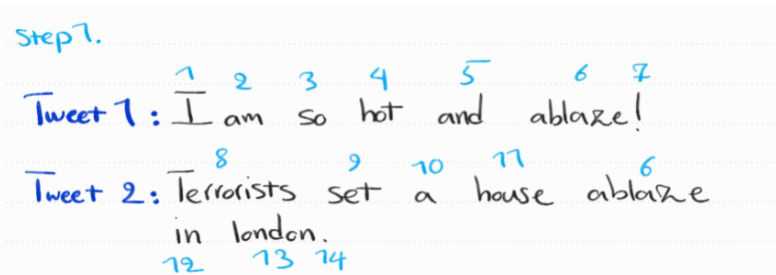

2.	With those digits we turn each tweet into a list of numbers.
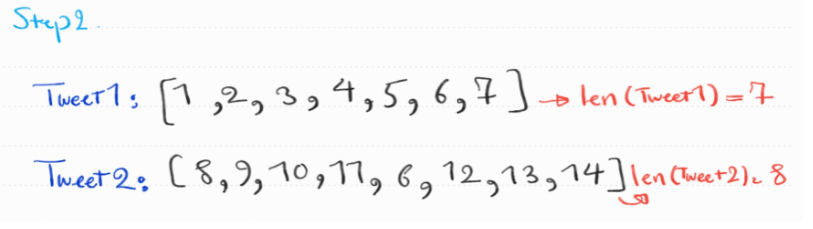

3.	Those list of numbers have to have the same length so we put enough zeros at the end of each tweet (these zeros are called paddings.)
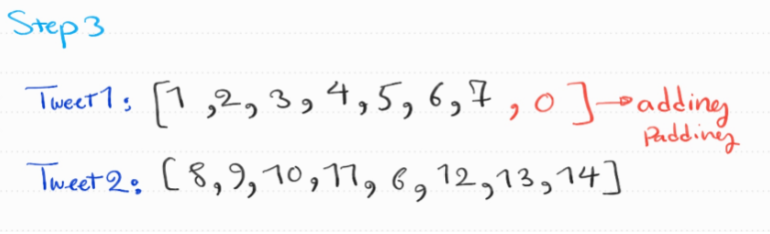

4.	We give all the digitized, padded tweets to our NN first layer. This layer is called Embedding Layer. What it does is that it turns each digit(word) into an array. We set the dimension of these arrays and the values are set by the Embedding layer. These values are determined based on the meaning and connection of each word to other words.
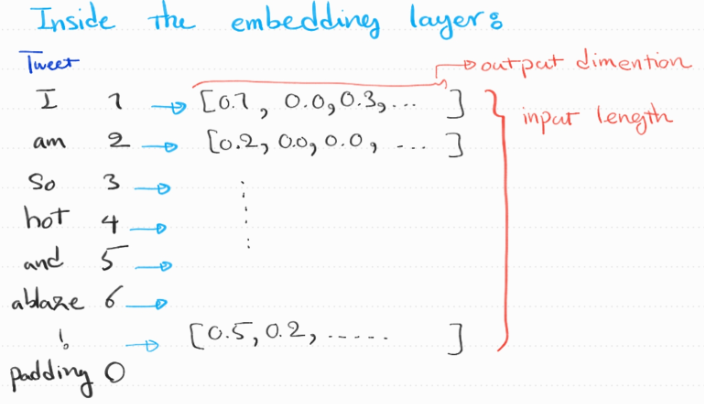

6.	Then we use average pooling to get an average of all these values. By doing this we reduce the dimension and get the gist of all the arrays in one number.
7.	The other layer of the network are constructed like a normal NN and you can decide on how many they should be
8.	Be careful though. You have to set the last layer to have a sigmoid activation function because we want to get either 0 or 1.


<a id="Text_embedding"></a>
# Text embeddings and Setting the initial weights for our NN

This is a step by step guideline of this section:
1. Creating a vocabulary of our tweets

2. Giving each word an index 

3. Creating a matrix for initial weights

4. Filling the matrix with GloVe vectors

In [ ]:
# specifying the maximum length of each tweet
maximum = 0
for tweet in df_concat.cleaned_text:
    x = len(tweet.split())
    if x > maximum:
        maximum = x
        
print(maximum)

In [ ]:
# creating a vocab of my data
vocab_of_text = set(" ".join(df_concat.text).lower().split())


# creating a dictionary of vocab with index starting with 1
# because index 0 will be for our padding
vocab_of_text = dict(enumerate(vocab_of_text, 1))


# putting the words first and then indices
indexed_vocab_of_text = {k:v for v,k in dict(vocab_of_text).items()}



def text_to_sequence_my_vocab(text, word_index):
    tokens = text.lower().split()
    return [word_index.get(token) for token in tokens if word_index.get(token) is not None]


# giving ids

df_concat['sequences'] = df_concat.text\
.apply(lambda x : text_to_sequence_my_vocab(x, indexed_vocab_of_text))

max_len_seq = 34

# padding

padded = pad_sequences(df_concat['sequences'] ,
              maxlen = max_len_seq, padding = 'post', 
              truncating = 'post')


padded.shape # this is (len(train)+len(test) ,max_len_seq)

padded_train = padded[:train.shape[0]]
padded_test = padded[train.shape[0]:]

In [ ]:
# creating a matrix for initial weights
dim = 300
vocab_matrix = np.zeros((len(indexed_vocab_of_text)+1, dim))



# searching for vactor of each word in Glove
for word, i in indexed_vocab_of_text.items():
    

    # embedding index is a dictionary of Glove
    # with the shape of 'word': vecor
    vector = glove_dict_vector.get(word)
    
    if vector is not None:
        vocab_matrix[i] = vector

# check that the matrix of weights is not empty
# and there's no bug in your code with
# np.all(vocab_matrix == 0)

<a id="NeuralNetwork_model"></a>
# **NeuralNetword Model**

In [ ]:
model = keras.models.Sequential()

embedding = keras.layers.Embedding(input_dim=len(indexed_vocab_of_text)+1, 
                                   output_dim= dim , mask_zero = True,
                                   embeddings_initializer=Constant(vocab_matrix),
                                   trainable = True,
                                   input_length = max_len_seq)
model.add(embedding)
model.add(keras.layers.AveragePooling1D())
model.add(keras.layers.LSTM(50, dropout=0.2, recurrent_dropout = 0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()


#optimizer = SGD(learning_rate = 0.1, momentum = 0.4 )

model.compile(optimizer = 'Adam',
              loss = keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = 'accuracy')


In [ ]:

x_train, x_test, y_train, y_test = train_test_split(padded_train, train.target, shuffle = True) 

model.fit(x = x_train, y = y_train, batch_size= 200, epochs = 3,
          validation_data = (x_test, y_test))

In [ ]:
# now you can submit your predictions

model.fit(x = padded_train, y = train.target,
          epochs = 3, batch_size = 200, verbose = 2)

y_pred = model.predict(padded_test)

In [ ]:

submission = pd.DataFrame(columns = ['id', 'target'])
submission['id'] = ids.astype('int')
submission['target'] = np.round(y_pred).flatten().astype('float64')

submission.to_csv('submission.csv', index=False)

<a id="Cross_Validation_for_NN"></a>
# Cross Validation in Neural Netword

In [ ]:

losses = []
accuracies = []
epoch_evaluation = {}
batch_s = 200
epochs = 5
k = 4

kfold = StratifiedKFold(n_splits = k, shuffle = True)

for i, (train_idx, val_idx) in enumerate(kfold.split(padded_train, train.target), 1):
    
    print('Fold: ', i)
    model = keras.models.Sequential()
    embedding = keras.layers.Embedding(input_dim=len(indexed_vocab_of_text)+1, 
                                    output_dim=dim , mask_zero = True,
                                    embeddings_initializer=Constant(vocab_matrix),
                                    trainable = False,
                                    input_length = max_len_seq)
    model.add(embedding)
    model.add(keras.layers.AveragePooling1D())
    model.add(keras.layers.LSTM(50))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer = 'adam',
              loss = keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = 'accuracy')

    history = model.fit(x = padded_train[train_idx],
              y = train.target[train_idx],
              validation_data= (padded_train[val_idx],
                                 train.target[val_idx]),
              batch_size= batch_s, epochs = epochs, verbose = 0)
    

    epoch_evaluation['Fold '+ str(i)] = history.history
    


In [ ]:
for i in range(1,k+1):
    fig, ax_ = plt.subplots(figsize = (8,4))


    ax_.plot(range(epochs), epoch_evaluation['Fold ' + str(i)]['accuracy'], label = 'training');
    ax_.plot(range(epochs), epoch_evaluation['Fold ' + str(i)]['val_accuracy'], label = 'val');
    leg = ax_.legend();

    plt.xlabel('epochs');
    plt.ylabel('accuracy');

<a id = 'gridsearch'></a>
# Grid Search for Neural Network

We can check the parameters of our neural network and make sure they're the best parameters we could give our model by using GridSearch. This a capability of scikit-learn library and we can bring it in our game by only using a wraper to wrap Keras models.


Jason Brownlee talks about this extensively on his [amazing blog](https://machinelearningmastery.com/). I suggest you check it out. But in summary you can check the following parameters: 
* Batch_size and number of Epochs
* Optimization Algorithm
* Learning Rate and Momentum (in case you used SGD)
* Weight Initialization
* Neuron Activation Function
* Dropout rate

and so on...

Here will have a gridsearch on the batch size and epochs.

Just like a normal GridSearch here too, we will define the parameters ranges and give it to the model. The difference here is that we have to wrap our model with  a KerasClassifer (if we had a regression problem we could do it with KerasRegressor).


Resources and very helpful notebooks :

[Gunes Evitan](https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)

[Shahules](https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove)

[help in Stackoverflow](https://stats.stackexchange.com/questions/246512/convolutional-layers-to-pad-or-not-to-pad)
